### GLM-eb
@authors: J. Carpenter, B.A. Dunn

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import scipy as sp
from scipy import io as sio
import statistics
import mat73
import glmmod

#### load dataset (choose a. or b.):

load sample data OR

In [2]:
# load & format sample data
filepath = 'sampleData_e.mat'
mat = sio.loadmat(filepath)
ST = mat['ST']
P = mat['P']
hd = np.radians(mat['hd']) #*(np.pi/180) # [0,2pi] rad

load blackstad data

In [3]:
# # load blackstad data
# filepath = 'C:\\Users\\17145\\OneDrive - NTNU\\Documents\\methods-project\\data_code\\curatedUnitsJS\\passuPython.mat'
# filepath_pos = 'C:\\Users\\17145\\OneDrive - NTNU\\Documents\\methods-project\\data_code\\curatedUnitsJS\\P.mat'
# mat = scipy.io.loadmat(filepath)

# mat_pos = mat73.loadmat(filepath_pos)

set visualization params

In [4]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rc('axes', labelsize=10); plt.rc('axes', titlesize=10)
plt.style.use('seaborn-bright'); plt.rc('font', size=10);

initialize class instance

In [5]:
# initialize class instance
g = glmmod.glm(ST,P,hd)

# cell's spiketrain (raw and speed-filtered)
smooth_fr, raw_spktrn, filt, dt = g.conv_spktrain() # get spiketrain (raw = convolved)
spiketrain = g.speed_threshold(raw_spktrn)

In [6]:
# get test/train indices (same for each model)
kfoldIdx, kfoldIdx_df = g.kfoldSplit(spiketrain, nfolds=10)

search for the best egocentric reference point via grid search

C:\Users\jordannc\.conda\envs\egoGLM\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


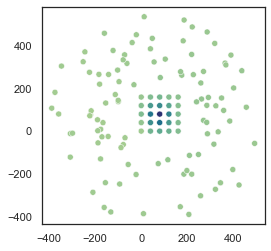

In [7]:
boxLen = g.get_size()
enlarge = 10
M = 5

# make grid inside box
X_inside,Y_inside = np.meshgrid(np.linspace(0,boxLen+enlarge,M),np.linspace(0,boxLen+enlarge,M))

# make grid outside box
limMax = 500; limMin = 175
n_outside_points = 100
X_outside = np.zeros((n_outside_points))
Y_outside = np.zeros((n_outside_points))

for ptNum in range(n_outside_points):
    radius = limMax + (limMin - limMax) * random.random()
    theta = (2*np.pi) * random.random()
    X_outside[ptNum] = radius * np.cos(theta) + (boxLen/2)
    Y_outside[ptNum] = radius * np.sin(theta) + (boxLen/2)

refX = np.append(X_inside,X_outside)
refY = np.append(Y_inside,Y_outside)
npoints = len(refX)

llhSearch = [] 
llhSearchMean = []
bestParamSearch = [] 

mt = 'E' # working with egocentric bearing model

for pnt in range(npoints):
    RP = [refX[pnt], refY[pnt]]

    ebgrid_raw,ego,_ = g.eb_map(nbins=10, rp=RP) # here we assume the reference point
    ebgrid = g.speed_threshold(ebgrid_raw)

    statemat, expr = g.squish_statemat(spiketrain, ebgrid, modelType='E')

    # initialize with best-fit parameters from previous run
    if pnt > 0:
        initParam = kres[0].x[:] # this should call kres from the previous iteration (before its overriden)
    else:
        initParam =  np.ones((10, ))*1e-3

    kres, train_y, test_y, train_x, test_x, data, param = g.kfoldOptim(kfoldIdx_df,statemat,initParam,modelType='E')

    testfit = g.get_testFit('E',kres,train_y,test_y,train_x,test_x)

    bestParamSearch.append(kres[0].x[:])
    llhSearch.append(testfit['llh_test'][:])
    llhSearchMean.append(np.nanmean(testfit['llh_test'][:]))

    del testfit

# vstack arrays outside loop (to save time in loop)
bestParamSearch = np.vstack(bestParamSearch)
llhSearch = np.vstack(llhSearch)
llhSearchMean = np.vstack(llhSearchMean)

# find the best fit reference point
maxLLHidx,_ = np.where(llhSearchMean==np.amax(llhSearchMean))
maxLLHidx = maxLLHidx[0]

# reference point to use
RP = [refX[maxLLHidx], refY[maxLLHidx]]

# visualize results of grid search
b = np.reshape(llhSearchMean, (1,len(llhSearchMean)))
b = b[0]
sns.set_theme(style='white')
gplot = sns.scatterplot(x=refX, y=refY, hue=b,palette="crest", legend = False)


In [8]:
numUnits = 1
llh_err_units = {}
best_model_units = {}
u = 1

print('unit ' + str(u))
t_raw = P[:,0]; dt = t_raw[1]-t_raw[0];

# calculate state matrices
posgrid_raw,_ = g.pos_map(nbins=10)
ebgrid_raw,ego,_ = g.eb_map(nbins=10, rp=RP) # here we assume the reference point
hdgrid_raw,_ = g.hd_map(nbins=10) 

# speed filter state matrices
posgrid = g.speed_threshold(posgrid_raw)
ebgrid = g.speed_threshold(ebgrid_raw)
hdgrid = g.speed_threshold(hdgrid_raw)


# dictionaries with info about each model
stateDict = {
    0: [posgrid,ebgrid],
    1: posgrid,
    2: ebgrid,
    3: hdgrid,
    4: [posgrid,hdgrid]
}

labelDict = {
    0: 'PE',
    1: 'P',
    2: 'E',
    3: 'H',
    4: 'PH'
}

allModels = {}
numModels = 5

unit 1


iterate through all models of interest (5 total)

In [14]:
for model in range(numModels):

    mt = labelDict[model]
    print('processing model ' + str(model) + ' (' + mt + ') ...')

    # get state matrix
    stateIn = stateDict[model]
    statemat, expr = g.squish_statemat(spiketrain, stateIn, modelType=mt)

    # optimize model parameters
    # warnings.filterwarnings("ignore", category=FutureWarning)
    _,n = np.shape(statemat); initParam = np.ones((n-1, ))*1e-3
    kres, train_y, test_y, train_x, test_x, data, param = g.kfoldOptim(kfoldIdx_df,statemat,initParam,modelType=mt)

    # check the model fit

    testfit = g.get_testFit(mt,kres,train_y,test_y,train_x,test_x)

    # package outputs
    modelPackage = g.packageOutput(kfoldIdx_df,kres,train_y,train_x,test_y,test_x,testfit) # FIX

    # save in allModels dictionary
    allModels[model] = modelPackage

    del stateIn

processing model 0 (PE) ...
processing model 1 (P) ...
processing model 2 (E) ...
processing model 3 (H) ...
processing model 4 (PH) ...


select best model

In [10]:
# model selection
llh, bestModel = g.modelSelection(allModels,labelDict,procedure="forward")

# LLH values for all folds and models
T = allModels[model]['testfit']['llh_test']
llhKfold = {'PE': allModels[0]['testfit']['llh_test'], 'P': allModels[1]['testfit']['llh_test'],
'E': allModels[2]['testfit']['llh_test'], 'H': allModels[3]['testfit']['llh_test'], 'PH': allModels[4]['testfit']['llh_test']};
llhKfold_df = pd.DataFrame.from_dict(llhKfold)

llhKfold_df

best model: E


,PE,P,E,H,PH
0,0.589244,0.096251,0.568409,-0.021567,0.060103
1,0.487501,-0.095704,0.489737,-0.004910,-0.074997
2,0.540982,0.055276,0.510255,-0.002087,0.092860
3,0.513674,0.094261,0.506162,0.012836,0.106865
4,0.441467,0.013068,0.417960,0.018839,0.078549
5,0.617605,0.094109,0.611763,0.044923,0.141403
6,0.723956,0.176231,0.709573,-0.029986,0.180576
7,0.618317,0.052144,0.603590,0.047236,0.118619
8,0.584286,0.110127,0.571477,0.013916,0.108087
9,0.737744,0.000623,0.739065,0.016287,0.101379


check model convergence

In [11]:
count = 0
allCount = 0
for model in range(5):
    for i in range(10):
        conStat = allModels[model]['kres'][i].success
        allCount = allCount + 1
        if conStat == True:
            count = count + 1
perConverge = 100*(count/allCount)
print('model convergence = ' + str(perConverge) + '%')

model convergence = 100.0%


plot results of LLH ratio tests

C:\Users\jordannc\AppData\Local\Temp\ipykernel_32572\1744479030.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


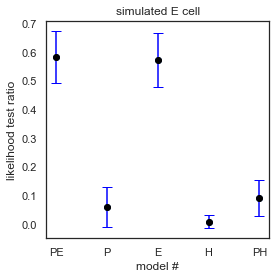

In [12]:
x_err = np.zeros((5,1))
x_mean = np.zeros((5,1))
XX = np.arange(5)
for model in range(5):
    x_err[model] = np.std(allModels[model]['testfit']['llh_test'])
    x_mean[model] = np.mean(allModels[model]['testfit']['llh_test'])

x_mean = np.transpose(x_mean)[0]
x_err = np.transpose(x_err)[0]

labels = ["PE", "P", "E", "H", "PH"]

fig, ax = plt.subplots()
plt.scatter(labels,x_mean)
plt.errorbar(labels, x_mean, yerr = x_err, fmt='o',ecolor = 'blue',color='black', capsize=5)
plt.xlabel('model #'); plt.ylabel('likelihood test ratio')
plt.title('simulated E cell')

ax.set_xticklabels(labels)

plt.show()


check out best-fit parameters

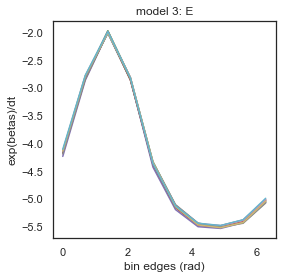

In [15]:
model = 2
for i in range(10):
    bp = allModels[model]['kres'][i]['x']
    bpExp = np.exp(bp)/g.dt
    plt.plot(np.linspace(0, 2*np.pi,len(bp)),bp)

plt.title('model 3: E');
plt.xlabel('bin edges (rad)');
plt.ylabel('exp(betas)/dt');